# Gaussian Filtering

## Background

A gaussian filter is placed over an image to perform blurring of the image.

### Input ### 
Given Image
### Process ### 
Create a Gaussian Filter and apply to the image
### Output ### 
Filtered Image
### Steps ###
1. Start by writing a function ``gauss`` which creates a 1D Gaussian from a given vector of integer indices $\mathtt{x = [-w, \ldots, w]}$:
$$
    \mathtt{G[i]} = \frac{1}{\sqrt{2\pi}\sigma}\operatorname{exp}\biggl(-\frac{\mathtt{x[i]}^2}{2\sigma^2}\biggr)
$$
where $\sigma$ is the standard deviation.

2. Implement the function `gaussian_filter(image, sigma, padding)`, which first generates a Gaussian filter and then applies it to the `image`. The Gaussian is separable, *i.e.* that an equivalent 2D result can be obtained through a sequence of two 1D filtering operations.

3. Use different sigmas to see the effect of blurring.

4. Use OpenCV built-in function for filtering

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

In [6]:
def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

In [7]:
# 1. Define Gaussian
def gauss(x, sigma):
    return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-x**2 / (2 * sigma**2))

<IPython.core.display.Javascript object>


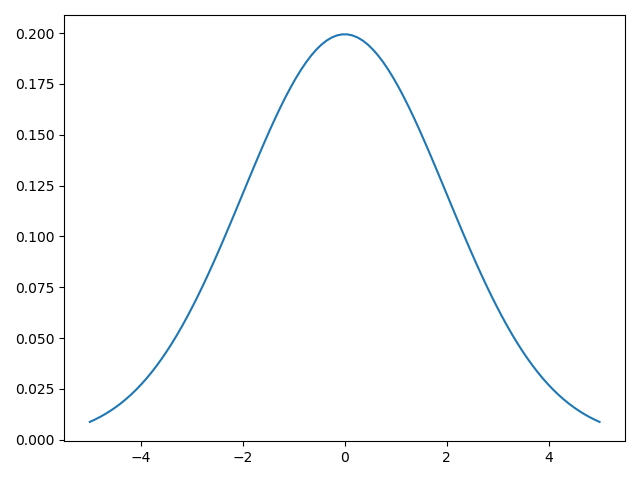

In [8]:
x = np.linspace(-5, 5, 100)
y = gauss(x, sigma=2)
fig, ax = plt.subplots()
ax.plot(x, y)
fig.tight_layout()

In [9]:
# 2. Implement the Gaussian filter on the image as 2 1D Gaussian filters
def gaussian_filter(image, sigma, padding=True):
    # Generate 1D kernel
    ks_half = int(np.ceil(3 * sigma))
    x = np.linspace(-ks_half, ks_half, 2*ks_half + 1, dtype=float)
    kernel = gauss(x, sigma)
    kernel = kernel / np.sum(kernel)

    # Expand kernel to handle 3-channel image
    kernel = np.expand_dims(kernel, axis=-1)

    # Add border
    if padding:
        image = cv2.copyMakeBorder(
            image, ks_half, ks_half, ks_half, ks_half,
            cv2.BORDER_DEFAULT)

    # Create an image to store intermediate result
    # of the row-wise filtering
    image_tmp = np.empty_like(image)

    # Apply row filter
    for i in range(image.shape[0]):
        for j in range(ks_half, image.shape[1] - ks_half):
            image_roi = image[i, j-ks_half:j+ks_half+1]
            image_tmp[i, j] = np.sum(image_roi * kernel, axis=0)

    # Apply column filter
    for i in range(ks_half, image.shape[0] - ks_half):
        for j in range(image.shape[1]):
            image_roi = image_tmp[i-ks_half:i+ks_half+1, j]
            image[i, j] = np.sum(image_roi * kernel, axis=0)

    # Crop border
    if padding:
        image = image[ks_half:-ks_half, ks_half:-ks_half]

    return image

<IPython.core.display.Javascript object>


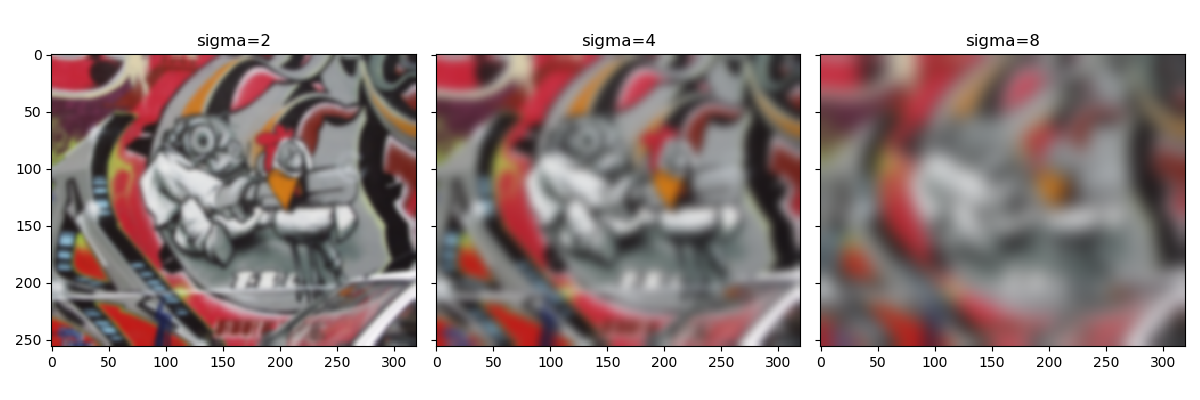

In [12]:
# Use different sigmas to see the effect of blurring
image = imageio.imread('graf_small.png')
sigmas = [2, 4, 8]
blurred_images = [gaussian_filter(image, s) for s in sigmas]
titles = [f'sigma={s}' for s in sigmas]

plot_multiple(blurred_images, titles)

<IPython.core.display.Javascript object>


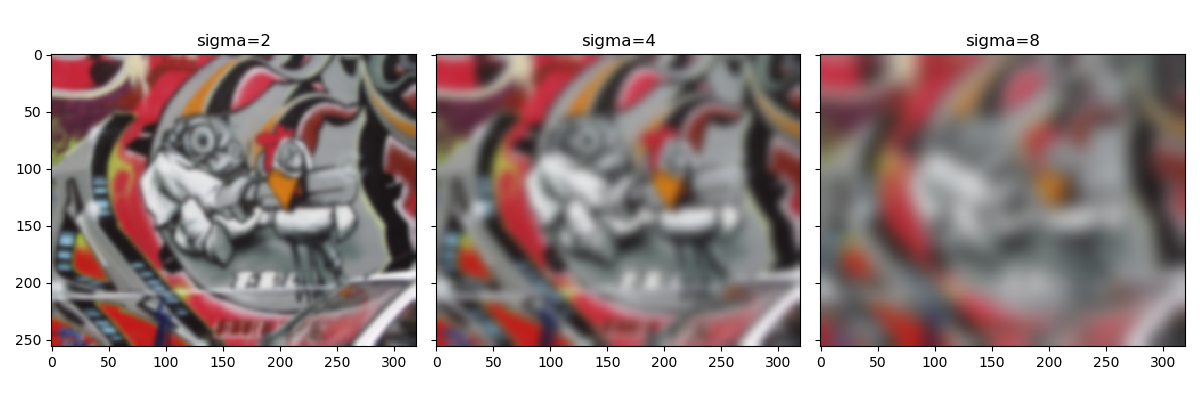

<IPython.core.display.Javascript object>


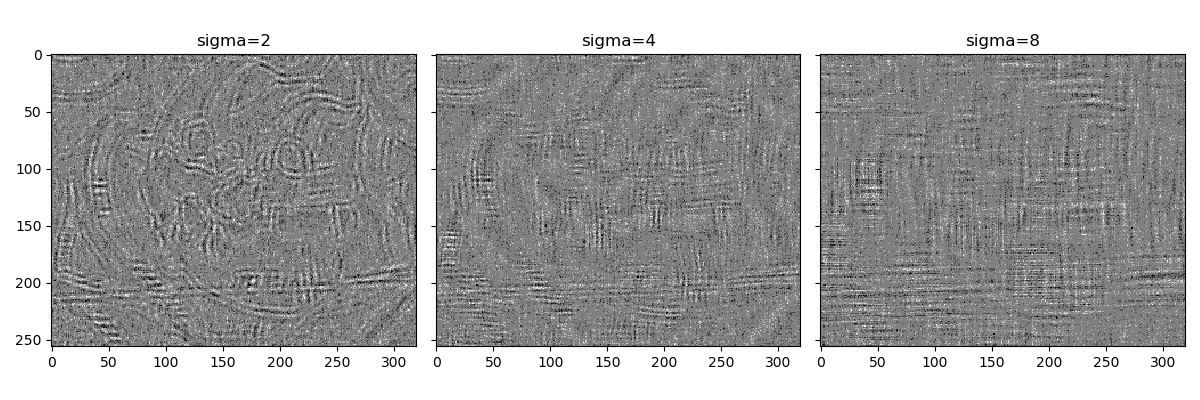

In [13]:
# 4. Use OpenCV built in function for Gaussian filtering
def gauss_cv(image, sigma):
    ks = 2 * int(np.ceil(3 * sigma)) + 1
    return cv2.GaussianBlur(image, (ks, ks), sigma, cv2.BORDER_DEFAULT)

def abs_diff(image1, image2):
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    return np.mean(np.abs(image1-image2), axis=-1)

blurred_images_cv = [gauss_cv(image, s) for s in sigmas]
differences = [abs_diff(x,y) for x, y in zip(blurred_images, blurred_images_cv)]

plot_multiple(blurred_images_cv, titles)
plot_multiple(differences, titles)
